In [1]:
import pandas as pd
import numpy as np
import json

import pickle 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

In [36]:
import matplotlib.pyplot as plt

In [24]:
import seaborn as sns
sns.set_style('darkgrid')

In [31]:
sns.set(rc={'figure.figsize':(11.7,6.27)})

In [2]:
import os
import glob
def read_lines(fn):
    if not os.path.exists(fn):
        return []
    with open(fn, 'r', encoding='utf-8') as f:
        text = f.read()
    lines = text.split("\n")
    if lines[-1] == '':
        return lines[:-1]
    else:
        return lines

def write_lines(fn, lines, mode='w'):
    text_to_write = "\n".join(list(lines)) 
    with open(fn, encoding='utf-8', mode=mode) as f:
        f.write(text_to_write)

In [104]:
def show_cos_src_tgt_dataset(df, min_cos_src_tgt_sim=0):
    return df[df["cos_src_tgt"] <= min_cos_src_tgt_sim].sort_values("cos_src_tgt")

def show_cos_check_dataset(df, min_cos_check_sim=0):
    return df[df["cos_check"] <= min_cos_check_sim].sort_values("cos_check")

def plot_cos_src_tgt(df, col="cos_src_tgt"):
    return df[df["text_src"] != df["text_tgt"]][col].plot.hist(bins=30)

def show_statistic(df, len_before=0, show_rate=True):
    diff_len = len_before - len(df)
    print("Count of rows: ", len(df))
    if diff_len > 0:
        print("Diff count: ", diff_len)
    if show_rate==True:
        print("Count of rows with change: ", df['have_change'].sum())
        print("Rate of rows with change: ", round(df['have_change'].mean(),2))
    print()

def basic_clean(df, show = True, min_cos_src_tgt_sim = 0):
    len_start = len(df)
    print("Initial statistics")
    df['have_change'] = (df['text_src']!=df['text_tgt']).astype(int)
    show_statistic(df, len_start)
    
    print("Drop dulicates")
    len_before = len(df)
    df = df.drop_duplicates(subset=['text_src', 'text_tgt'])
    show_statistic(df, len_before, show_rate=True)
    
    print("Drop where len less 5 and less then 3 token")
    len_before = len(df)
    df = df[df["text_tgt"].str.len() > 5]
    df = df[df['text_tgt'].apply(lambda x: len(x.split(" ")) > 3)]
    show_statistic(df, len_before, show_rate=True)
    
    print("Drop where start from non-capital")
    len_before = len(df)
    df = df[df["text_tgt"].apply(lambda x: x[0] == x[0].upper())]
    show_statistic(df, len_before, show_rate=True)
    
#     print("Drop where for one src more than one target")
#     len_before = len(df)
#     val_count = df.text_src.value_counts()
#     index_to_delete = []
#     for text_src in val_count[val_count > 1].index:
#         sub_df = df[df.text_src == text_src]
#         res_ind = sub_df[sub_df["cos_src_tgt"] > 0.999].index
#         if len(res_ind):
#             index_to_delete.extend(res_ind)
#     df = df[~df.index.isin(index_to_delete)]
#     show_statistic(df, len_before, show_rate=True)
    
    print("Drop where cosine similarity between src and tgt is less than ", min_cos_src_tgt_sim)
    len_before = len(df)
    df = df[df["cos_src_tgt"] > min_cos_src_tgt_sim]
    show_statistic(df, len_before, show_rate=True)
    
    print('Final rate of cleaned data: ', round(len(df)/len_start,2))
    return df

### WL 

In [5]:
text_src = read_lines("../../data_parallel/wi+locness/train_src")
text_tgt = read_lines("../../data_parallel/wi+locness/train_tgt")

with open("../Clustering/data/wl_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/wl_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)
    
cos_sim_wl = []
for i in tqdm(range(len(vectors_src))):
    cos_sim_wl.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [6]:
wl_df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim_wl})

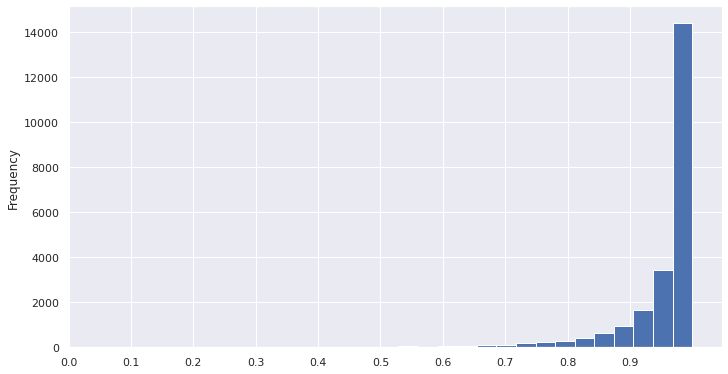

In [38]:
g = plot_cos_src_tgt(wl_df)
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

In [14]:
wl_df[wl_df["cos_src_tgt"] <= 0.75].sort_values("cos_src_tgt")

,text_src,text_tgt,cos_src_tgt,have_change
2380,I am stydying envaermantal saents .,I am studying environmental science .,0.057646,1
2557,And terolism is scare also .,And terrorism is scarce also .,0.166419,1
13529,Good Morning :,Dear Sir / Madam,0.186326,1
5518,fsdjgdofg,,0.196443,1
23629,Rest is anything but completely different .,The rest is completely different .,0.201329,1
...,...,...,...,...
9245,"If you need any further information , please d...","If you need any further information , please d...",0.749603,1
10,I have my own plan too but I do n't same to th...,"I have my own plan too , but I do n't want to ...",0.749714,1
14018,"First of all , the vanue itself was very crowd...","First of all , the venue itself was very crowd...",0.749718,1
7997,than the practice makes the rest .,then practice does the rest .,0.749757,1


In [13]:
clean_wl = basic_clean(wl_df, show = True, min_cos_src_tgt_sim=0.75)

Initial statistics
Count of rows:  34308
Count of rows with change:  22744
Rate of rows with change:  0.66

Drop dulicates
Count of rows:  33493
Diff count:  815
Count of rows with change:  22717
Rate of rows with change:  0.68

Drop where len less 5 and less then 3 token
Count of rows:  32343
Diff count:  1150
Count of rows with change:  22566
Rate of rows with change:  0.7

Drop where start from non-capital
Count of rows:  32083
Diff count:  260
Count of rows with change:  22379
Rate of rows with change:  0.7

Drop where for one src more than one target
Count of rows:  32071
Diff count:  12
Count of rows with change:  22379
Rate of rows with change:  0.7

Drop where cosine similarity between src and tgt is less than  0.75
Count of rows:  31490
Diff count:  581
Count of rows with change:  21798
Rate of rows with change:  0.69

Final rate of cleaned data:  0.92


### Nucle

In [15]:
text_src = read_lines("../../data_parallel/nucle/nucle_src")
text_tgt = read_lines("../../data_parallel/nucle/nucle_tgt")

with open("../Clustering/data/nucle_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/nucle_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)
    
cos_sim = []
for i in tqdm(range(len(vectors_src))):
    cos_sim.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [16]:
with open("../Checkpoint_exp/nucle_cos.pickle", "rb") as f:
    cos_check = pickle.load(f)

In [17]:
nucle_df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim, "cos_check": cos_check})

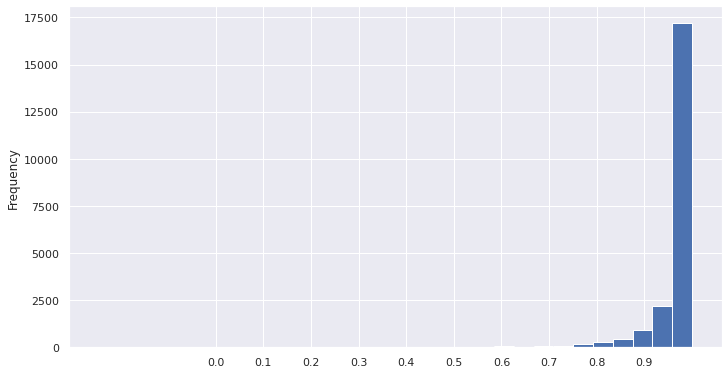

In [35]:
g = plot_cos_src_tgt(nucle_df)
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

In [60]:
clean_nucle = basic_clean(nucle_df, show = True, min_cos_src_tgt_sim=0.9)

Initial statistics
Count of rows:  57151
Count of rows with change:  21834
Rate of rows with change:  0.38

Drop dulicates
Count of rows:  53681
Diff count:  3470
Count of rows with change:  21830
Rate of rows with change:  0.41

Drop where len less 5 and less then 3 token
Count of rows:  52343
Diff count:  1338
Count of rows with change:  21559
Rate of rows with change:  0.41

Drop where start from non-capital
Count of rows:  51967
Diff count:  376
Count of rows with change:  21328
Rate of rows with change:  0.41

Drop where for one src more than one target
Count of rows:  51944
Diff count:  23
Count of rows with change:  21328
Rate of rows with change:  0.41

Drop where cosine similarity between src and tgt is less than  0.9
Count of rows:  50295
Diff count:  1649
Count of rows with change:  19679
Rate of rows with change:  0.39

Final rate of cleaned data:  0.88


### FCE

In [40]:
text_src = read_lines("../../data_parallel/fce/fce_train_src")
text_tgt = read_lines("../../data_parallel/fce/fce_train_tgt")

with open("../Clustering/data/fce_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/fce_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)
    
cos_sim = []
for i in tqdm(range(len(vectors_src))):
    cos_sim.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [41]:
with open("../Checkpoint_exp/fce_cos.pickle", "rb") as f:
    cos_check = pickle.load(f)

In [42]:
fce_df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim, "cos_check": cos_check})

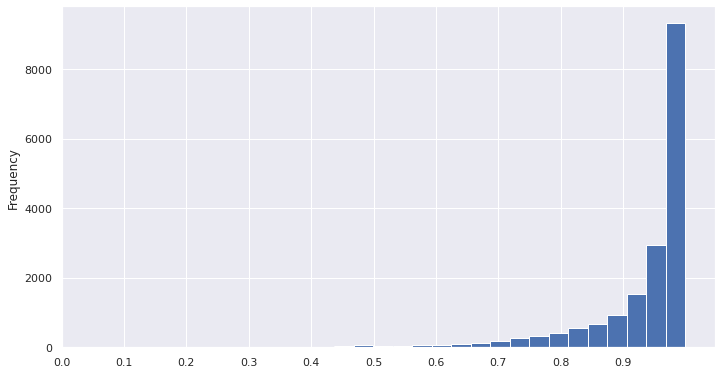

In [43]:
g = plot_cos_src_tgt(fce_df)
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

In [57]:
show_cos_src_tgt_dataset(fce_df, min_cos_src_tgt_sim=0.8)

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
18933,befor the beggining ?,before the beginning ?,0.061627,0.963681,1
25815,i was abset of it .,I was upset about it .,0.083509,0.977990,1
15235,It was alwais the saim .,It was always the same .,0.095632,0.974045,1
14886,Becaue,Because,0.147442,0.946754,1
17632,Staying in a que or croude is also unplesent .,Staying in a queue or crowd is also unpleasant .,0.157074,0.975612,1
...,...,...,...,...,...
18732,We will pay Curly 's doctor with these money t...,We will pay Curly 's vet with the money that w...,0.799752,0.976555,1
18962,"As you can see , there are some ( volontary ? ...","As you can see , there are some ( deliberate ?...",0.799798,0.980210,1
14639,"Another problem is , I realised that the disco...",Another problem is I thought that discounts we...,0.799831,0.979086,1
2114,"I do n't really want to change that , I think ...","I do n't really want to change that , I think ...",0.799891,0.980476,1


In [55]:
fce_df.loc[7278].values

array(['I would like to travel only in July because I will take some hollydays at this time .',
       'I would like to travel only in July because I will have some holiday at that time .',
       0.7999153137207031, 0.97819734, 1], dtype=object)

In [58]:
clean_fce = basic_clean(fce_df, show = True, min_cos_src_tgt_sim=0.8)

Initial statistics
Count of rows:  28350
Count of rows with change:  17742
Rate of rows with change:  0.63

Drop dulicates
Count of rows:  25707
Diff count:  2643
Count of rows with change:  17540
Rate of rows with change:  0.68

Drop where len less 5 and less then 3 token
Count of rows:  24610
Diff count:  1097
Count of rows with change:  17300
Rate of rows with change:  0.7

Drop where start from non-capital
Count of rows:  24529
Diff count:  81
Count of rows with change:  17246
Rate of rows with change:  0.7

Drop where for one src more than one target
Count of rows:  24507
Diff count:  22
Count of rows with change:  17246
Rate of rows with change:  0.7

Drop where cosine similarity between src and tgt is less than  0.8
Count of rows:  23098
Diff count:  1409
Count of rows with change:  15837
Rate of rows with change:  0.69

Final rate of cleaned data:  0.81


## Lang8

In [61]:
text_src = read_lines("../../data_parallel/lang8/lang8_src")
text_tgt = read_lines("../../data_parallel/lang8/lang8_tgt")

with open("../Clustering/data/lang8_train_src_embed.pickle", "rb") as f:
    vectors_src = pickle.load(f)

with open("../Clustering/data/lang8_train_tgt_embed.pickle", "rb") as f:
    vectors_tgt = pickle.load(f)
    
cos_sim = []
for i in tqdm(range(len(vectors_src))):
    cos_sim.append(cosine_similarity([vectors_src[i]],[vectors_tgt[i]])[0,0])

In [63]:
with open("../Checkpoint_exp/lang8_cos.pickle", "rb") as f:
    cos_check = pickle.load(f)

In [64]:
lang8_df = pd.DataFrame({"text_src": text_src, "text_tgt": text_tgt, "cos_src_tgt": cos_sim, "cos_check": cos_check})

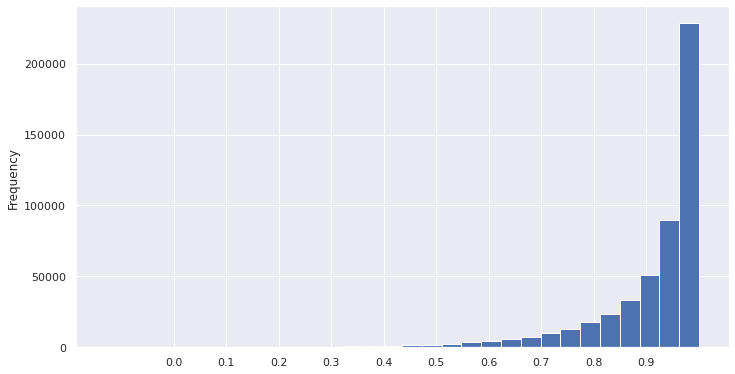

In [65]:
g = plot_cos_src_tgt(lang8_df)
plt.xticks(np.arange(0, 1, 0.1))
plt.show()

In [66]:
show_cos_src_tgt_dataset(lang8_df, min_cos_src_tgt_sim=0.8)

,text_src,text_tgt,cos_src_tgt,cos_check
300445,So I do easy to the society 's exchange .,I do n't understand this phrase .,-0.129838,0.976939
504480,is japanese holiday .,.,-0.107871,0.976343
620960,Because I like fish .,See above .,-0.077993,0.978164
746006,I can t explain how it ached . . .,kotoba ni naranai kurai itai . . .,-0.077581,0.976457
542854,The show started .,Incomplete sentence .,-0.069533,0.975724
...,...,...,...,...
20133,"Consequently , we have a hard time economicaly...","Consequently , we now have a hard time living ...",0.799991,0.978727
991930,"Actually , many companies lately try to establ...","Actually , lately many companies have recently...",0.799992,0.970962
18822,"We take a walk a littel , then I heard dog 's ...","We t walked a bit , then I heard a dog bark .",0.799995,0.977029
516642,"Yesterday , I send e - mail to my professor wi...","Yesterday , I sent an email to my professor wi...",0.799996,0.980873


In [67]:
lang8_df.loc[991930].values

array(['Actually , many companies lately try to establish new management systems by juggling teamwork and outstanding characters .',
       'Actually , lately many companies have recently been trying to establish new management systems by finding a balance between teamwork and individual success .',
       0.7999920845031738, 0.9709615], dtype=object)

In [70]:
clean_lang8 = basic_clean(lang8_df, show = True, min_cos_src_tgt_sim=0.8)

Initial statistics
Count of rows:  1037561
Count of rows with change:  499205
Rate of rows with change:  0.48

Drop dulicates
Count of rows:  950886
Diff count:  86675
Count of rows with change:  497292
Rate of rows with change:  0.52

Drop where len less 5 and less then 3 token
Count of rows:  902102
Diff count:  48784
Count of rows with change:  491604
Rate of rows with change:  0.54

Drop where start from non-capital
Count of rows:  855065
Diff count:  47037
Count of rows with change:  469462
Rate of rows with change:  0.55

Drop where cosine similarity between src and tgt is less than  0.8
Count of rows:  795260
Diff count:  59805
Count of rows with change:  409657
Rate of rows with change:  0.52

Final rate of cleaned data:  0.77


In [71]:
import copy

In [72]:
merge = copy.deepcopy(clean_lang8)
merge = merge.append(clean_nucle)
merge = merge.append(clean_fce)
merge = merge.append(clean_wl)

In [121]:
len(merge)

900143

In [123]:
merge.have_change.sum()

466971

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
train, dev = train_test_split(merge, test_size=0.02, random_state=4)

In [76]:
train_src = train.text_src.values 
train_tgt = train.text_tgt.values 
dev_src = dev.text_src.values 
dev_tgt = dev.text_tgt.values 

In [77]:
path_save = "../../data_parallel/base_clean_gold/"

In [78]:
write_lines(path_save+"train_src", train_src, mode='w')
write_lines(path_save+"train_tgt", train_tgt, mode='w')
write_lines(path_save+"dev_src", dev_src, mode='w')
write_lines(path_save+"dev_tgt", dev_tgt, mode='w')

### Clean with checkpoints

### FCE

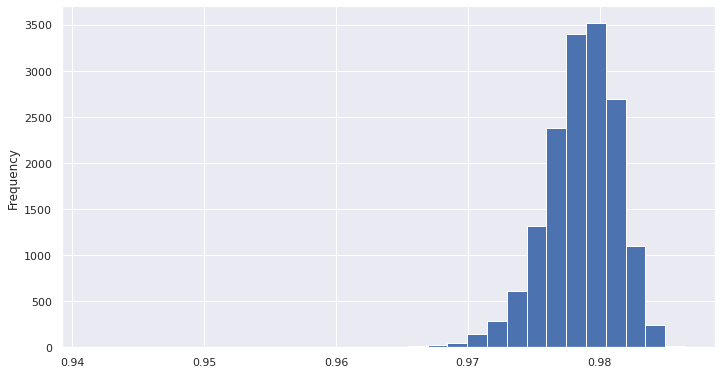

In [97]:
g = plot_cos_src_tgt(clean_fce, col="cos_check")

In [106]:
sh = show_cos_check_dataset(clean_fce, min_cos_check_sim=0.975)
sh[sh['have_change'] == 1]

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
5884,"Dear Sir/ Madame ,","Dear Sir/ Madam ,",0.808469,0.941449,1
3549,Your faithfully Jose Fernandez,"Yours faithfully , Jose Fernandez",0.942777,0.944115,1
179,Dear Helen Ryan,"Dear Helen Ryan ,",0.987902,0.945434,1
22449,"Dear Madam Ryan ,","Dear Ms Ryan ,",0.809835,0.946956,1
16327,Dear Madam or Sir,Dear Sir or Madam,0.982242,0.947401,1
...,...,...,...,...,...
3119,She has given away to my mother that I told he...,She has given it away to my mother that I told...,0.995717,0.974992,1
27108,I am sure you understand why I am so upset and...,I am sure you understand why I am so upset and...,0.998905,0.974996,1
19504,"If I pick up the example , Kimono ( Japanese t...","If I pick up an example , the Kimono ( traditi...",0.924326,0.974998,1
6155,Modern technology have change my daily life in...,Modern technology has changed my daily life in...,0.990995,0.974998,1


In [89]:
len(clean_fce)

23098

In [107]:
clean_fce_check = clean_fce[clean_fce["cos_check"] > 0.975]

In [108]:
len(clean_fce_check)

19245

### Nucle

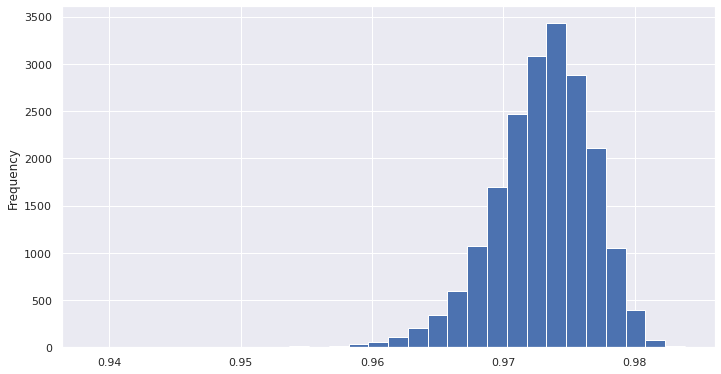

In [109]:
g = plot_cos_src_tgt(clean_nucle, col="cos_check")

In [119]:
sh = show_cos_check_dataset(clean_nucle, min_cos_check_sim=0.975)
sh[sh['have_change'] == 1]

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
12926,The Wikipedia claims that intensive farming is...,Wikipedia claims that intensive farming is an ...,0.984283,0.938626,1
6840,There are also retraining and upgrading progra...,There are also retraining and upgrading progra...,0.971904,0.943413,1
30561,( { http : //bbs.chinadaily.com.cn/redirect.ph...,( { http : //bbs.chinadaily.com.cn/redirect.ph...,0.996778,0.944728,1
55784,"( Christiana , J. , Cirella , N. , Lee , B. , ...","( ( Christiana.J . et al , 2007 ) ) Furthermor...",0.954420,0.945996,1
27902,"The accident rate per 10,000 vehicles has incr...","The accident rate per 10,000 vehicles has incr...",0.955128,0.946621,1
...,...,...,...,...,...
6568,Human genetics has made tremendous leaps over ...,Human genetics has made tremendous leaps over ...,0.999520,0.974997,1
22434,This result in a process where identifying the...,This results in a process where identifying th...,0.998870,0.974997,1
31914,This counter argument is good but it may be no...,This counter argument is good but it may be no...,0.981090,0.974999,1
19631,The government has a duty in taking care of th...,The government has a duty to take care of the ...,0.985434,0.975000,1


In [120]:
clean_nucle_check = clean_nucle[clean_nucle["cos_check"] > 0.975]

### Lang8

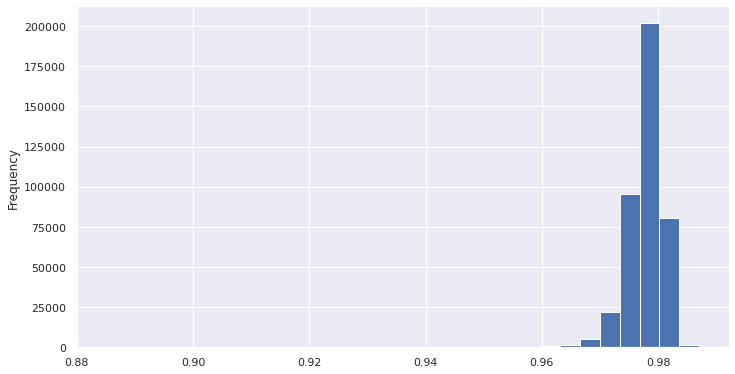

In [116]:
g = plot_cos_src_tgt(clean_lang8, col="cos_check")

In [125]:
sh = show_cos_check_dataset(clean_lang8, min_cos_check_sim=0.975)
sh[sh['have_change'] == 1]

,text_src,text_tgt,cos_src_tgt,cos_check,have_change
848187,hello ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ...,Hello ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ...,0.938659,0.884925,1
441516,exciting,Exciting or An exciting picture,0.880587,0.893824,1
636988,My homework is so heavy ! ! ! ! ! ! ! ! ! ! ! ...,I have so much homework ! ! ! ! ! ! ! ! ! ! ! ...,0.815322,0.894128,1
907850,Willy Coyote,Wile E . Coyote,0.887032,0.898402,1
504669,WHY ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !,WHY ? ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !,0.853729,0.905077,1
...,...,...,...,...,...
353081,Is Kuruneko popular in children ?,Is Kuruneko popular with children ?,0.994654,0.975000,1
588769,It 's six million yen .,It was filled with six million yen .,0.960215,0.975000,1
868792,"We do n't know why he has got recovered , any ...","We do n't know why he has recovered , anyway w...",0.928414,0.975000,1
650649,`` God help those who help themselves ! ``,`` God helps those who help themselves ! ``,0.939081,0.975000,1


In [126]:
clean_lang8_check = clean_lang8[clean_lang8["cos_check"] > 0.975]

In [127]:
merge_check = copy.deepcopy(clean_lang8_check)
merge_check = merge_check.append(clean_nucle_check)
merge_check = merge_check.append(clean_fce_check)
merge_check = merge_check.append(clean_wl)

In [128]:
len(merge_check)

681202

In [129]:
merge_check.have_change.sum()

392061

In [131]:
train, dev = train_test_split(merge_check, test_size=0.02, random_state=4)

In [132]:
train_src = train.text_src.values 
train_tgt = train.text_tgt.values 
dev_src = dev.text_src.values 
dev_tgt = dev.text_tgt.values 

In [134]:
path_save = "../../data_parallel/check_clean_gold/"

In [135]:
write_lines(path_save+"train_src", train_src, mode='w')
write_lines(path_save+"train_tgt", train_tgt, mode='w')
write_lines(path_save+"dev_src", dev_src, mode='w')
write_lines(path_save+"dev_tgt", dev_tgt, mode='w')